In [121]:
import os
import os.path
from os import path
import numpy as np
import ccdproc
from astropy.io import fits,ascii
from astropy.nddata import CCDData
import sys
sys.path.append(r"C:\Users\david\raw")
from srp2 import *
from wcalib import *
from astropy import units as u
import statistics
from scipy.ndimage import uniform_filter
import matplotlib.pyplot as plt; plt.rcdefaults()
import re
from astropy.time import Time
from astropy.time import TimeDelta
import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)
from astropy.coordinates import SkyCoord, EarthLocation
from scipy.interpolate import interp1d


In [3]:
csv_filename=r"C:\Users\david\raw\Log.csv" 
input_list =np.loadtxt(csv_filename, dtype={'names':('filename', 'type'), 'formats':('U20','U20')}, delimiter=',',usecols=(0,1),skiprows=(0))
np.savetxt(r'C:\Users\david\raw\input_list',input_list,fmt='%s,%s', delimiter=',', header='filename,type', comments='')

In [4]:
imtypes = np.array(input_list['type'])
biasims, = np.where(imtypes == 'biases')
bias_stack = []
for bb in biasims:
    filename = input_list['filename'][bb].strip()
    if '-' in filename:
        base_filename = filename.split('-')[0] + '-'
        start, end = filename.split('-')
        for i in range(int(start), int(end) + 1):
            number_str = str(i).zfill(4)
            file_path = os.path.join(r'C:\Users\david\raw\Data', 'GM113022-'+number_str + '.fit')
            bias_stack.append(file_path)
    else:
        file_path = os.path.join(r'C:\Users\david\raw\Data', filename + '.fit')
        if os.path.exists(file_path):
            bias_stack.append(file_path)
output_file = r'C:\Users\david\raw\MasterBias.fits'
if os.path.exists(output_file):
    os.remove(output_file)
masterbias = ccdproc.combine(bias_stack, output_file=r'C:\Users\david\raw\MasterBias.fits',method='average',sigma_clip=True,sig_clip_low_thresh=3,sig_clip_high_thresh=3,unit="adu", overwrite=True)


In [5]:
flatdarkims, = np.where(imtypes == 'darks')
darkims, = np.where(imtypes == 'darksthirty')
flatdark_stack = []
for fd in flatdarkims:
    filename = input_list['filename'][fd].strip()
    if '-' in filename:
        base_filename = filename.split('-')[0] + '-'
        start, end = filename.split('-')
        for i in range(int(start), int(end) + 1):
            number_str = str(i).zfill(4)
            file_path = os.path.join(r'C:\Users\david\raw\Data', 'GM113022-'+number_str + '.fit')
            flatdark_stack.append(file_path)
    else:
        file_path = os.path.join(r'C:\Users\david\raw\Data', filename + '.fit')
        if os.path.exists(file_path):
            flatdark_stack.append(file_path)
output_file = r'C:\Users\david\raw\MasterFlatDark.fits'
if os.path.exists(output_file):
    os.remove(output_file)
masterflatdark = ccdproc.combine(flatdark_stack,output_file=r'C:\Users\david\raw\MasterFlatDark.fits',method='average',sigma_clip=True,sig_clip_low_thresh=1.5,sig_clip_high_thresh=1.5,unit="adu",overwrite=True)
dark_stack = []
for dd in darkims:
    filename = input_list['filename'][dd].strip()
    if '-' in filename:
        base_filename = filename.split('-')[0] + '-'
        start, end = filename.split('-')
        for i in range(int(start), int(end) + 1):
            number_str = str(i).zfill(4)
            file_path = os.path.join(r'C:\Users\david\raw\Data', 'GM113022-'+number_str + '.fit')
            dark_stack.append(file_path)

    else:
        file_path = os.path.join(r'C:\Users\david\raw\Data', filename + '.fit')
        if os.path.exists(file_path):
            dark_stack.append(file_path)


output_file = r'C:\Users\david\raw\MasterDark.fits'
if os.path.exists(output_file):
    os.remove(output_file)
masterdark = ccdproc.combine(dark_stack,output_file=r'C:\Users\david\raw\MasterDark.fits',method='median',sigma_clip=True,sig_clip_low_thresh=3.0,sig_clip_high_thresh=3.0,unit="adu",overwrite=True)
	



In [6]:
flatims, = np.where(imtypes == 'flats')
flat_stack = []
for ff in flatims:
    filename = input_list['filename'][ff].strip()
    if '-' in filename:
        base_filename = filename.split('-')[0] + '-'
        start, end = filename.split('-')
        for i in range(int(start), int(end) + 1):
            number_str = str(i).zfill(4)
            file_path = os.path.join(r'C:\Users\david\raw\Data', 'GM113022-'+number_str + '.fit')
            flat_stack.append(file_path)
    else:
        file_path = os.path.join(r'C:\Users\david\raw\Data', filename + '.fit')
        if os.path.exists(file_path):
            flat_stack.append(file_path)
output_file = r'C:\Users\david\raw\MasterFlat.fits'
if os.path.exists(output_file):
    os.remove(output_file)
masterflat = ccdproc.combine(flat_stack,output_file=r'C:\Users\david\raw\MasterFlat.fits',method='average',sigma_clip=True,sig_clip_low_thresh=3,sig_clip_high_thresh=3,unit="adu",overwrite=True)

In [7]:
 masterflat=CCDData.read(r'C:\Users\david\raw\MasterFlat.fits')
masterflatdark=CCDData.read(r'C:\Users\david\raw\MasterFlatDark.fits')  
masterflatdarksub = ccdproc.subtract_dark(masterflat,masterflatdark,dark_exposure=10.0*u.second,data_exposure=10.0*u.second)
ccdproc.fits_ccddata_writer(masterflatdarksub,r'C:\Users\david\raw\MasterFlat_DarkSub.fits',overwrite=True)

In [8]:
 masterflat=CCDData.read(r'C:\Users\david\raw\MasterFlat_DarkSub.fits')
FLAT_trim = ccdproc.trim_image(masterflat[95:166,:])
ccdproc.fits_ccddata_writer(FLAT_trim,'FLAT_trim.fits', overwrite=True)
FS = boxcar(FLAT_trim,30,9,'reflect')
ccdproc.fits_ccddata_writer(FS,'FS.fits',overwrite=True)
FLAT = ccdproc.flat_correct(FLAT_trim,FS)
ccdproc.fits_ccddata_writer(FLAT,r'C:\Users\david\raw\MasterFlat_Final.fits',overwrite=True)

In [9]:
if os.path.exists(r'C:\Users\david\raw\MasterDark_BiasSub.fits'):
  os.remove(r'C:\Users\david\raw\MasterDark_BiasSub.fits')
masterdark=CCDData.read(r'C:\Users\david\raw\MasterDark.fits')
masterbias=CCDData.read(r'C:\Users\david\raw\MasterBias.fits')  
masterdarkbiassub = ccdproc.subtract_bias(masterdark,masterbias)
crop = ccdproc.trim_image(masterdarkbiassub[95:166,:])
ccdproc.fits_ccddata_writer(crop,r'C:\Users\david\raw\MasterDark_BiasSub.fits')



In [10]:
masterbias=CCDData.read(r'C:\Users\david\raw\MasterBias.fits') 
filename = r'C:\Users\david\raw\Data\GM113022-0015.fit'
a2 = CCDData.read(filename,unit="adu")
a3 = ccdproc.subtract_bias(a2,masterbias)
a4 = ccdproc.trim_image(a3[95:166,:])
ccdproc.fits_ccddata_writer(a4,r'C:\Users\david\raw\Processed_WaveCal.fits',overwrite=True)

In [11]:
masterbias=CCDData.read(r'C:\Users\david\raw\MasterBias.fits') 
masterdark=CCDData.read(r'C:\Users\david\raw\MasterDark_BiasSub.fits')
masterflat=CCDData.read(r'C:\Users\david\raw\MasterFlat_Final.fits')
filename = r'C:\Users\david\raw\Data\GM113022-0018.fit'
s2 = CCDData.read(filename,unit="adu")
s3 = ccdproc.subtract_bias(s2,masterbias)
s4 = ccdproc.trim_image(s3[95:166,:])
s5 = ccdproc.subtract_dark(s4,masterdark,dark_exposure=300.0*u.second,data_exposure=300.0*u.second)
s6 = ccdproc.flat_correct(s5,masterflat)
ccdproc.fits_ccddata_writer(s6,'Reduced_Object.fits',overwrite=True)

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


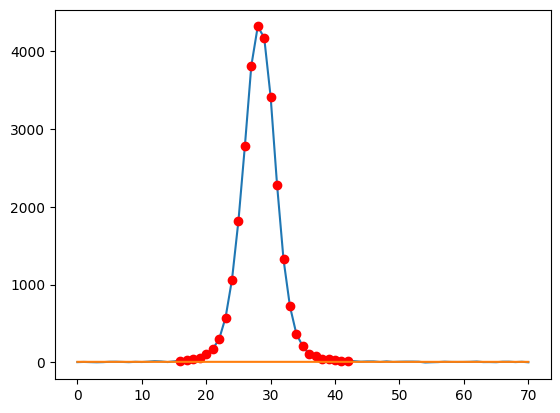

In [41]:
spectrum = ("Reduced_Object.fits")
line = int(("800"))
deg = 1 #This is the degree of the polynomial to be fit to the background
low = 3.0 #This is low sigma level for rejecting points below the fitted curve
high = 3.0 #This is the high sigma level for rejecting points above the fitted curve.  These last two variables are set so that the object spectrum and cosmic rays are not included in the background estimation

s1 = CCDData.read(spectrum,unit="adu")
himage = fits.open(spectrum)
naxis1 = int(himage[0].header['NAXIS1'])
naxis2 = int(himage[0].header['NAXIS2'])

#determine background
x,y = scan_single_line(s1,naxis1,naxis2,line)
p,points = fit_background_line(s1,naxis1,naxis2,line,deg,low,high)

#plot results
plt.plot(x,y)
fitx = []
fity = []
for i in range(naxis2):
    fitx.append(x[i])
    fity.append(p(x[i]))
    if(points[i] == 0):
        plt.plot(x[i],y[i],'ro')

plt.plot(fitx,fity)
plt.savefig('try_background_fit.png')
plt.show()


In [45]:
#Removes old versions of output files
if os.path.exists("background.fit"):
	os.remove("background.fit")
  
if os.path.exists("bkgnd_subtracted.fit"):
	os.remove("bkgnd_subtracted.fit")

trace = Trace()

spectrum = ("Reduced_Object.fits")
deg = 1 #This is the degree of the polynomial to be fit to the background
low = 3.0 #This is low sigma level for rejecting points below the fitted curve
high = 3.0 #This is the high sigma level for rejecting points above the fitted curve.  These last two variables are set so that the object spectrum and cosmic rays are not included in the background estimation

#deg = 1, low = 3.0 high = 2.5 works


s1 = CCDData.read(spectrum,unit="adu")
himage = fits.open(spectrum)
naxis1 = int(himage[0].header['NAXIS1'])
naxis2 = int(himage[0].header['NAXIS2'])

#Retrieve Trace
get_trace(s1,naxis1,naxis2,10,trace)
fit_trace(trace,1,naxis1)
#Make Background image
background = make_background_image(s1,naxis1,naxis2,deg,low,high)
background.write('background.fit')
#Subtract Background
s1_back = s1.subtract(background)
s1_back.write('bkgnd_subtracted.fit')

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


In [119]:
gain = 3.97 # Set the gain of the CCD
read_noise = 1.0 # Set the read noise level
bg_deg = 1 # degree of polynomial to use for background estimate, determined in the previous step involving background subtraction
bg_sig_low = 2.5 #This is low sigma level for rejecting points below the fitted curve
bg_sig_high = 2.0 #This is the high sigma level for rejecting points above the fitted curve.  This and the previous variables are set so that the object spectrum and cosmic rays are not included in the background estimation
trace_deg = 5 # degree of polynomial for the trace
ws_deg = 5 # degree of polynomial for wavelength solution
grating=600 #the grating used, mostly for bookkeeping

DSO = EarthLocation(lat=36.2529*u.deg,lon=-81.4151*u.deg,height=932*u.m) # specify observing location, also mostly for bookkeeping

spectrum = ("Reduced_Object.fits")
name=("Hot_Star")
arc1=CCDData.read("Processed_WaveCal.fits")
N=1 #number of object images to be reduced and combined
path_to_template=("template.dat") 
path_to_template_data=("template_fit.dat")


#spectra=["Reduced_Object.fits", "Processed_WaveCal.fits"]
#spectra=["bkgnd_subtracted.fit"]
#name="29 Psc"
#arc1=CCDData.read("Processed_WaveCal.fits")
#N=1
#wave_cor_600="template_fit.dat"
#path_to_template="template.dat" 
#path_to_template_data="template_fit.dat"

#These last few lines just add additional bookkeeping output to our output files
add_keywords = {'TELESCOP': 'DSO 32-in','INSTRUME': 'GM Spectrograph','EPOCH': 'J2000','GRATING':'%s g/mm' % grating} 
output_keywords = ['TELESCOP','INSTRUME','PROJECT','OBJECT','RA','DEC','AIRMASS','NUMEXP','EXPTIME','DATE-OBS','DATE-MID','JD','JD-MID','JD-HELIO','BARYCOR','GRATING']
ext="txt"

#This is where the magic happens!  Perform background subtraction, extract the spectrum and output to a 1D spectrum, both a text file and fits file
optimal_extract_and_combine(spectra,name,arc1,arc1,N,wave_cor_600,path_to_template,path_to_template_data,gain,read_noise,bg_deg,bg_sig_low,bg_sig_high,trace_deg,ws_deg,add_keywords,output_keywords,ext)

INFO: overwriting NDData's current unit with specified unit. [astropy.nddata.nddata]
sd = 0.022520
sd = 0.022520


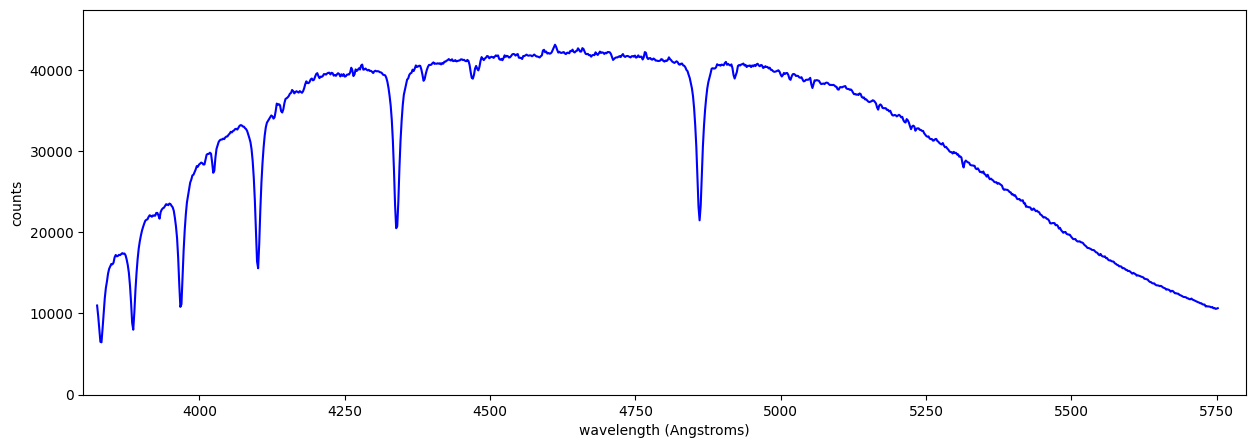

In [127]:
name=("Hot_Star.txt")
 
lambda1, counts= np.loadtxt(name, max_rows=1024,unpack=True)

plt.figure(figsize=(15,5))

plt.plot(lambda1, counts, color='blue')

maxy=max(counts)

plt.axis([3800, 5800, 0, 1.1*maxy])
plt.xlabel('wavelength (Angstroms)')
plt.ylabel('counts')
plt.savefig('Hot_Star.png')
plt.show()